# 4. Clustering

Qinghai University for Nationalities, *Python Data Analysis in Finance* course, machine learning part.

Author: *cloudy-sfu*

## Data pre-processing

Read the Iris dataset.

In [1]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
x = iris.data

Perform standardization.

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_std = scaler.fit_transform(x)

View the correlation between variables.

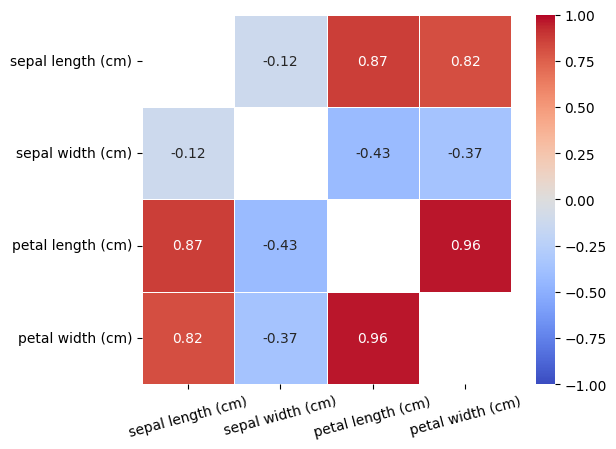

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

@np.vectorize
def decimal_non_zero(x):
    return format(x, '.2f')

x_corr = np.corrcoef(x, rowvar=False)

fig, ax = plt.subplots()
mask = np.zeros_like(x_corr, dtype=bool)
mask[np.diag_indices_from(mask)] = True
heatmap = sns.heatmap(x_corr, mask=mask, square=True, linewidths=.5, cmap='coolwarm',
                      vmin=-1, vmax=1, annot=decimal_non_zero(x_corr), fmt='')
ax.set_xticks(ticks=np.arange(x.shape[1]) + 0.5, labels=x.columns, rotation=15)
ax.set_yticks(ticks=np.arange(x.shape[1]) + 0.5, labels=x.columns, rotation=0)
fig.show()

## K-means clustering

The process of K-means clustering:

1. ~~Randomly put $k$ center points.~~ Selects $k$ centroids (center points) using sampling based on an empirical probability distribution of the points' contribution to the overall inertia.
2. Calculate the distance between each data point to the center points, and categorize it to whichever closest cluster.
3. With categorized data points, update the center points to their geometric center.
4. Calculate the distance between previous center points and current center points. If the distance is smaller than a tolerance $\epsilon$, stop; otherwise, repeat step 2-3.

Limitation:

1. You should know $k$.
2. It's sensitive to outliers.
3. ~~It's sensitive to the starting points.~~

Note: ~~deleted text~~ means the method from the classic algorithm. The limitation of that is resolved by K-means++ algorithm.

In Iris dataset, if we know $k = 3$, perform k-means clustering.

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init=1)
kmeans.fit(x_std)

KMeans(n_clusters=3, n_init=1)

Visualize the clustered results and center points. According to the correlation matrix, sepal length and sepal width can explain other two variables.

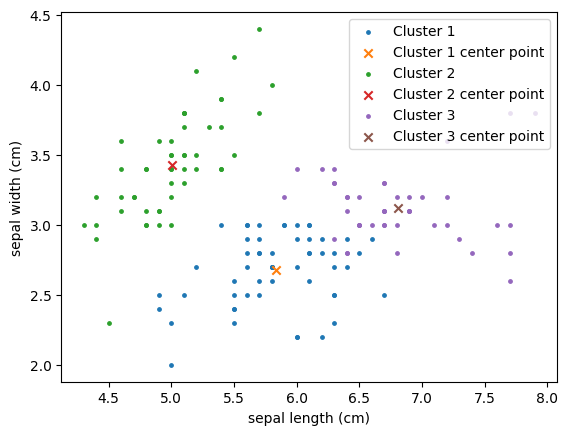

In [5]:
import pandas as pd

fig, ax = plt.subplots()
center_points = scaler.inverse_transform(kmeans.cluster_centers_)
center_points = pd.DataFrame(data=center_points, columns=x.columns)
for i in np.unique(kmeans.labels_):
    idx = kmeans.labels_ == i
    ax.scatter(x['sepal length (cm)'][idx], x['sepal width (cm)'][idx], 
               label=f'Cluster {i+1}', s=6)
    ax.scatter(center_points['sepal length (cm)'][i], center_points['sepal width (cm)'][i], 
               label=f'Cluster {i+1} center point', marker='x')
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('sepal width (cm)')
ax.legend()
fig.show()

## Model evaluation

If we don't know the ground truth, the category of iris, we could use silhouette metric to evaluate the quality of clustering.

In [6]:
from sklearn.metrics import silhouette_score

silhouette_score(x, kmeans.labels_)

0.4975582034115361

The metric ranges $[-1, 1]$.

- The best value is 1 and the worst value is -1. 
- Values near 0 indicate overlapping clusters.

We can use silhoette score to find the best $k$ if we don't know $k$.

In [7]:
kmeans_k = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=1)
    kmeans.fit(x_std)
    kmeans_k.append({
        'k': k,
        'silhouette_score': silhouette_score(x, kmeans.labels_)
    })
kmeans_k = pd.DataFrame(kmeans_k)

Draw the silhouette scores along with $k$ values. The model believes $k=2$ is the best. Since it's an unsupervised model, we shouldn't think $k=3$ is correct and others are wrong.

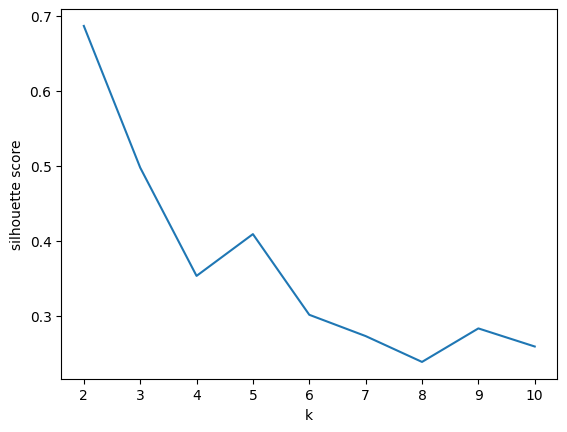

In [8]:
fig, ax = plt.subplots()
ax.plot(kmeans_k['k'], kmeans_k['silhouette_score'])
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')
fig.show()

## DBSCAN

The process of DBSCAN is:

1. Randomly pick a point and identify with $\epsilon$, `minPts`.
2. Repeat step 1 for the neighbors of core points recursively.
3. Stop until unable to include more points in this cluster.
4. Repeat steps 1-3 in the remaining set until all points are checked.

Limitation:

1. It's hard to find suitable $\epsilon$, `minPts`.

In [9]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1, min_samples=5)
dbscan.fit(x_std)

DBSCAN(eps=1)

Visualize the clustered results and center points. According to the correlation matrix, sepal length and sepal width can explain other two variables.

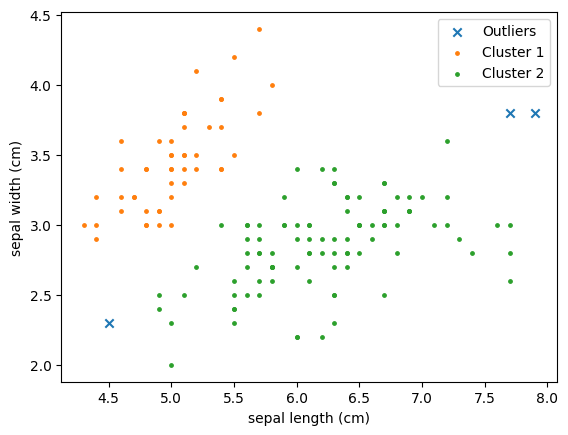

In [10]:
fig, ax = plt.subplots()

idx_outliers = dbscan.labels_ == -1
ax.scatter(x['sepal length (cm)'][idx_outliers], x['sepal width (cm)'][idx_outliers], 
           label='Outliers', marker = 'x')
dbscan_max_id = np.max(dbscan.labels_)
for i in range(dbscan_max_id + 1):
    idx = dbscan.labels_ == i
    ax.scatter(x['sepal length (cm)'][idx], x['sepal width (cm)'][idx], 
               label=f'Cluster {i+1}', s=6)
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('sepal width (cm)')
ax.legend()
fig.show()

We could also tune $\epsilon$ and `minPts` with silhouette score.

In [11]:
dbscan_hyperparameters = []

eps = np.linspace(0.2, 2, 11)
min_points = (2 ** np.linspace(1.5, 6, 10)).astype(int)
xx, yy = np.meshgrid(eps, min_points)
silhouette = np.zeros(shape=(min_points.shape[0], eps.shape[0]))

for i in np.arange(eps.shape[0]):
    for j in np.arange(min_points.shape[0]):
        dbscan = DBSCAN(eps=eps[i], min_samples=min_points[j])
        dbscan.fit(x_std)
        try:
            silhouette[j, i] = silhouette_score(x, dbscan.labels_)
        except ValueError:
            silhouette[j, i] = -1

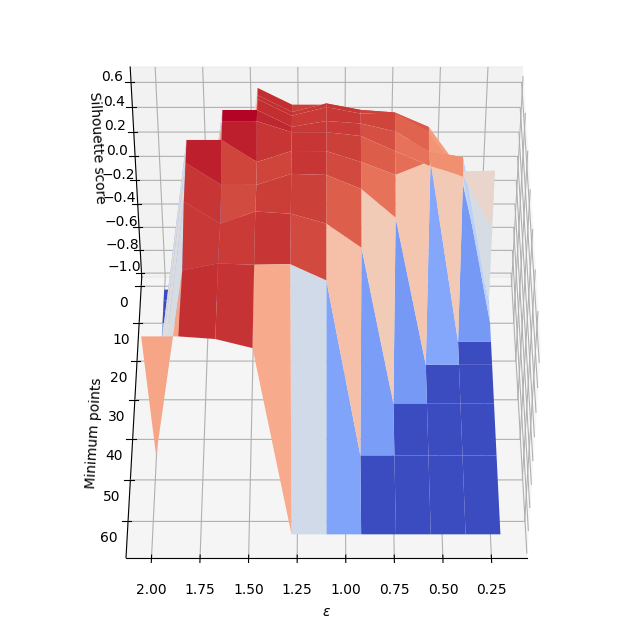

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xx, yy, silhouette, cmap='coolwarm')
ax.view_init(elev=30, azim=45)
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('Minimum points')
ax.set_zlabel('Silhouette score')
ax.view_init(elev=45, azim=90)
fig.show()